In [1]:
import pandas as pd
import numpy as nd
import os
import shutil
from PIL import Image
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from matplotlib.ticker import FormatStrFormatter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv("/content/drive/MyDrive/medical-ai-main/labels.csv")

In [4]:
data.head(2)

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP


In [5]:
finding = "cardiomegaly"
finding.capitalize()

'Cardiomegaly'

In [6]:
positive = data.loc[data["label"]  == "Cardiomegaly"]
negative =  data.loc[data["label"]  == "No Finding"]
n= len(positive)
print("positive-{}".format(n))
if n == 0:
    print("Check your spelling")

positive-146


In [7]:
TRAIN = 0.8
TEST = 0.2
TRAIN_N = int(n*TRAIN)
TEST_N = int(n*TEST)
print('TRAIN_N {} ,TEST_N {} '.format(TRAIN_N,TEST_N) )

TRAIN_N 116 ,TEST_N 29 


In [8]:
train_labels = pd.concat([positive[:TRAIN_N], negative[:TRAIN_N]])
test_labels = pd.concat([positive[TRAIN_N:], negative[TRAIN_N:n]])

In [9]:
os.makedirs(finding+"/test/positive",  exist_ok=True)
os.makedirs(finding+"/test/negative",  exist_ok=True)
os.makedirs(finding+"/train/positive", exist_ok=True)
os.makedirs(finding+"/train/negative", exist_ok=True)

In [10]:
# Define the source and destination directories
source_dir = "/content/drive/MyDrive/medical-ai-main/images"
positive_train_images = os.path.join(finding, "train", "positive")
positive_test_images = os.path.join(finding, "test", "positive")
negative_train_images = os.path.join(finding, "train", "negative")
negative_test_images = os.path.join(finding, "test", "negative")

# Create the destination directories if they don't exist
os.makedirs(positive_train_images, exist_ok=True)
os.makedirs(positive_test_images, exist_ok=True)
os.makedirs(negative_train_images, exist_ok=True)
os.makedirs(negative_test_images, exist_ok=True)


# Iterate through the positive DataFrame and copy files
for idx, image in positive[:TRAIN_N].iterrows():
    source_file = os.path.join(source_dir, image["filename"])
    destination_file = os.path.join(positive_train_images, image["filename"])

    try:
        shutil.copyfile(source_file, destination_file)
        print(f"Successfully copied: {source_file} -> {destination_file}")
    except FileNotFoundError:
        print(f"File not found: {source_file}")
    except Exception as e:
        print(f"An error occurred: {e}")


for idx, image in positive[TRAIN_N:].iterrows():
    source_file = os.path.join(source_dir, image["filename"])
    destination_file = os.path.join(positive_test_images, image["filename"])

    try:
        shutil.copyfile(source_file, destination_file)
        print(f"Successfully copied: {source_file} -> {destination_file}")
    except FileNotFoundError:
        print(f"File not found: {source_file}")
    except Exception as e:
        print(f"An error occurred: {e}")

for idx, image in negative[TRAIN_N:n].iterrows():
    source_file = os.path.join(source_dir, image["filename"])
    destination_file = os.path.join(negative_test_images, image["filename"])

    try:
        shutil.copyfile(source_file, destination_file)
        print(f"Successfully copied: {source_file} -> {destination_file}")
    except FileNotFoundError:
        print(f"File not found: {source_file}")
    except Exception as e:
        print(f"An error occurred: {e}")

for idx, image in negative[:TRAIN_N].iterrows():
    source_file = os.path.join(source_dir, image["filename"])
    destination_file = os.path.join(negative_train_images, image["filename"])

    try:
        shutil.copyfile(source_file, destination_file)
        print(f"Successfully copied: {source_file} -> {destination_file}")
    except FileNotFoundError:
        print(f"File not found: {source_file}")
    except Exception as e:
        print(f"An error occurred: {e}")

Successfully copied: /content/drive/MyDrive/medical-ai-main/images/00005066_030.jpg -> cardiomegaly/train/positive/00005066_030.jpg
Successfully copied: /content/drive/MyDrive/medical-ai-main/images/00009608_024.jpg -> cardiomegaly/train/positive/00009608_024.jpg
Successfully copied: /content/drive/MyDrive/medical-ai-main/images/00000661_000.jpg -> cardiomegaly/train/positive/00000661_000.jpg
Successfully copied: /content/drive/MyDrive/medical-ai-main/images/00019018_007.jpg -> cardiomegaly/train/positive/00019018_007.jpg
Successfully copied: /content/drive/MyDrive/medical-ai-main/images/00000211_041.jpg -> cardiomegaly/train/positive/00000211_041.jpg
Successfully copied: /content/drive/MyDrive/medical-ai-main/images/00015770_010.jpg -> cardiomegaly/train/positive/00015770_010.jpg
Successfully copied: /content/drive/MyDrive/medical-ai-main/images/00011463_002.jpg -> cardiomegaly/train/positive/00011463_002.jpg
Successfully copied: /content/drive/MyDrive/medical-ai-main/images/00021364_

In [11]:
def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return nd.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(nd.uint8)

In [12]:
import os
from PIL import Image

source_dir = "/content/drive/MyDrive/medical-ai-main/images"
positive_images = []
negative_images = []
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

for index, row in positive[:6].iterrows():
    image_path = os.path.join(source_dir, row['filename'])
    image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    positive_images.append(load_image_into_numpy_array(image))

for index, row in negative[:6].iterrows():
    image_path = os.path.join(source_dir, row['filename'])
    image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    negative_images.append(load_image_into_numpy_array(image))

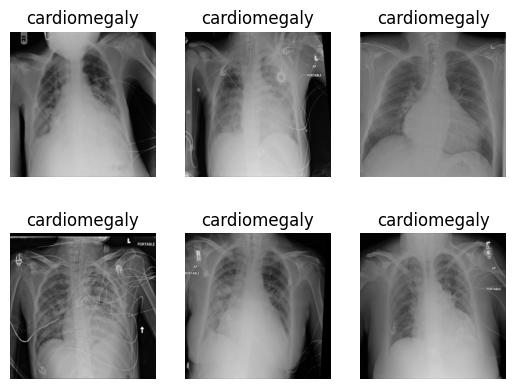

In [13]:
for i,img in enumerate(positive_images[:6]):
    plt.subplot(2,3,i+1)
    plt.imshow(positive_images[i]);
    plt.title("cardiomegaly")
    plt.axis('off')
plt.show();

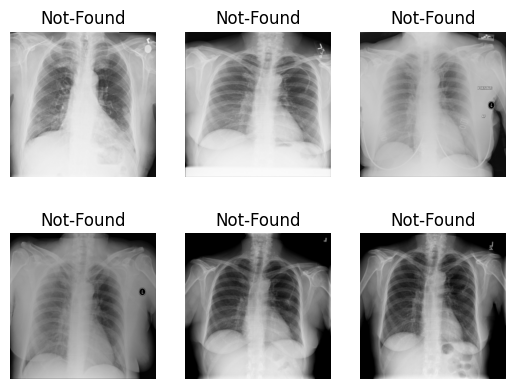

In [14]:
for i,img in enumerate(negative_images[:6]):
    plt.subplot(2,3,i+1)
    plt.title("Not-Found")
    plt.imshow(negative_images[i])
    plt.axis('off')
plt.show()

In [15]:
pre_train_model = InceptionV3(input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH,3),weights='imagenet',include_top=False)

for layer in pre_train_model.layers:
    layer.trainable = False

last_layer = pre_train_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(pre_train_model.input , x)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

In [16]:
rootdir = "/content/cardiomegaly"
source_dir = "/content/drive/MyDrive/medical-ai-main/images"
base_direc = rootdir

train_dir = os.path.join(base_direc,'train')
test_dir = os.path.join(base_direc,'test')

train_pos_dir = os.path.join(train_dir,'positive')
train_neg_dir = os.path.join(train_dir,'negative')
test_pos_dir = os.path.join(test_dir,'positive')
test_neg_dir = os.path.join(test_dir,'negative')

In [17]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)


val_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [19]:
train_steps = len(os.listdir(train_pos_dir))*2
test_steps = len(os.listdir(test_pos_dir)) * 2
print("train_steps {} , test_steps {}".format(train_steps,test_steps))

train_steps 232 , test_steps 60


In [20]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      validation_data=test_generator,
      validation_steps=test_steps,
      epochs=30,
      verbose=2)

Epoch 1/30
232/232 - 18s - loss: 11.1309 - acc: 0.4741 - val_loss: 4.4636 - val_acc: 0.6333 - 18s/epoch - 76ms/step
Epoch 2/30
232/232 - 10s - loss: 3.9244 - acc: 0.6724 - val_loss: 0.7175 - val_acc: 0.7000 - 10s/epoch - 45ms/step
Epoch 3/30
232/232 - 9s - loss: 1.4101 - acc: 0.6724 - val_loss: 0.7854 - val_acc: 0.6833 - 9s/epoch - 40ms/step
Epoch 4/30
232/232 - 10s - loss: 0.8470 - acc: 0.6422 - val_loss: 0.6835 - val_acc: 0.6000 - 10s/epoch - 43ms/step
Epoch 5/30
232/232 - 11s - loss: 0.5410 - acc: 0.7241 - val_loss: 0.5844 - val_acc: 0.7667 - 11s/epoch - 49ms/step
Epoch 6/30
232/232 - 11s - loss: 0.5836 - acc: 0.7198 - val_loss: 0.8917 - val_acc: 0.5667 - 11s/epoch - 48ms/step
Epoch 7/30
232/232 - 10s - loss: 0.5778 - acc: 0.7112 - val_loss: 0.5173 - val_acc: 0.7833 - 10s/epoch - 42ms/step
Epoch 8/30
232/232 - 9s - loss: 0.5250 - acc: 0.7328 - val_loss: 0.5804 - val_acc: 0.7000 - 9s/epoch - 38ms/step
Epoch 9/30
232/232 - 11s - loss: 0.5240 - acc: 0.7543 - val_loss: 0.7685 - val_acc:

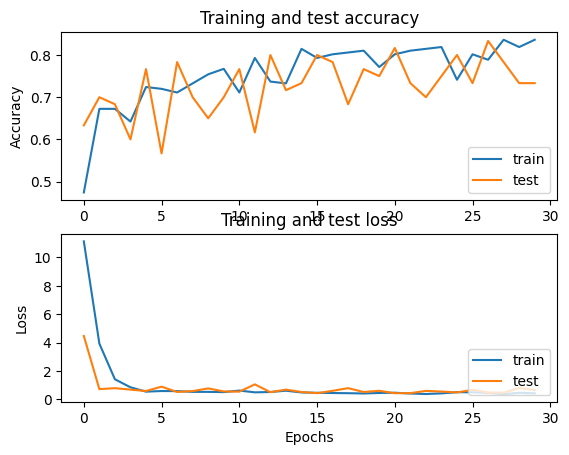

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")
plt.show()

In [22]:
def predict_image(filename):
    image = Image.open(filename).resize((IMAGE_HEIGHT,IMAGE_WIDTH))
    image_np = load_image_into_numpy_array(image)
    exp = nd.true_divide(image_np , 255.0)
    expand = nd.expand_dims(exp,axis=0)
    return model.predict(expand)[0][0]

def show_df_row(row):
    image_path = row["filepath"]
    image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    img = load_image_into_numpy_array(image)
    exp = nd.true_divide(img, 255.0)
    expanded = nd.expand_dims(exp, axis=0)
    pred = model.predict(expanded)[0][0]
    guess = "cardiomegaly-negative"
    if pred > 0.5:
        guess = "cardiomegaly-positive"
    title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
    plt.title(title)
    plt.imshow(img)
    plt.show()
    return

In [23]:
result = []
for image in os.listdir(test_pos_dir):
    filename = test_pos_dir+"/"+image
    prediction = predict_image(filename)
    guess = "cardiomegaly-positive" if prediction > 0.5 else "cardiomegaly-negative"
    result.append([filename,image,"cardiomegaly-positive",guess,prediction])

for image in os.listdir(test_neg_dir):
    filename = test_neg_dir+"/"+image
    prediction = predict_image(filename)
    guess = "cardiomegaly-postive" if prediction > 0.5 else "cardiomegaly-negative"
    result.append([filename,image,"cardiomegaly-negative",guess,prediction])

sorted_results = sorted(result, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","prediction"])

print("Done the prediction")

1/1 [==============================] - 0s 24ms/step
Done the prediction


In [24]:
df.to_csv('/content/drive/MyDrive/medical-ai-main/predic_cardiomegaly.csv')

1/1 [==============================] - 0s 26ms/step


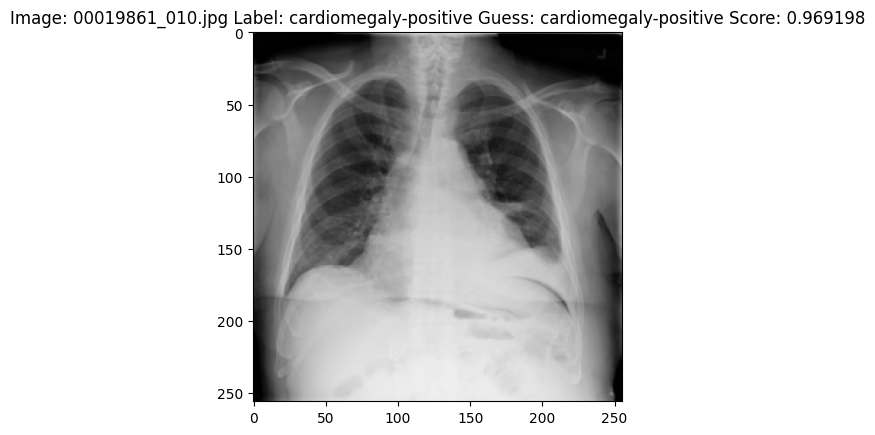

In [25]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

In [26]:
df[::5][['filename', 'label',"guess","prediction"]]

,filename,label,guess,prediction
0,00013615_052.jpg,cardiomegaly-positive,cardiomegaly-positive,0.999942
5,00011557_003.jpg,cardiomegaly-positive,cardiomegaly-positive,0.995923
10,00012686_003.jpg,cardiomegaly-positive,cardiomegaly-positive,0.987956
15,00022706_001.jpg,cardiomegaly-positive,cardiomegaly-positive,0.974464
20,00000080_003.jpg,cardiomegaly-negative,cardiomegaly-postive,0.962519
25,00004342_002.jpg,cardiomegaly-positive,cardiomegaly-positive,0.933261
30,00004344_014.jpg,cardiomegaly-positive,cardiomegaly-positive,0.889498
35,00000090_002.jpg,cardiomegaly-negative,cardiomegaly-postive,0.728870
40,00000086_000.jpg,cardiomegaly-negative,cardiomegaly-postive,0.603939
45,00000078_000.jpg,cardiomegaly-negative,cardiomegaly-negative,0.347571


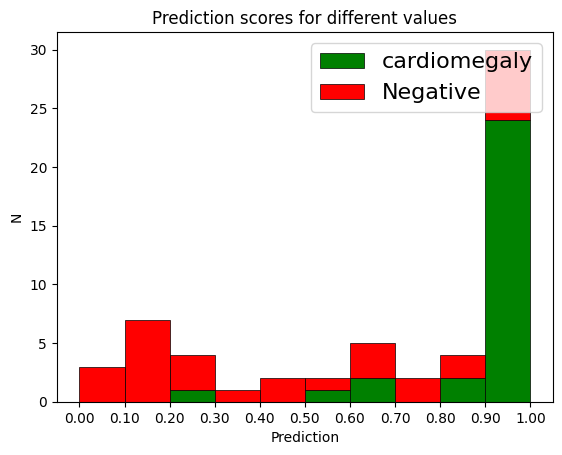

In [27]:
pos = df.loc[df['label'] == "cardiomegaly-positive"]["prediction"]
neg = df.loc[df["label"] == "cardiomegaly-negative"]["prediction"]

fig,ax = plt.subplots()
n, bins, patches = plt.hist([pos,neg], nd.arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5, density=False, histtype='bar', stacked=True, color=['green', 'red'], label=[finding, 'Negative'])
plt.xlabel('Prediction')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Prediction scores for different values')
plt.legend(loc="upper right", fontsize=16)
plt.show()

In [28]:
model.save('/content/export/'+finding)
!zip -r /content/{finding}.zip /content/export/{finding}

  adding: content/export/cardiomegaly/ (stored 0%)
  adding: content/export/cardiomegaly/fingerprint.pb (stored 0%)
  adding: content/export/cardiomegaly/keras_metadata.pb (deflated 96%)
  adding: content/export/cardiomegaly/saved_model.pb (deflated 92%)
  adding: content/export/cardiomegaly/variables/ (stored 0%)
  adding: content/export/cardiomegaly/variables/variables.index (deflated 78%)
  adding: content/export/cardiomegaly/variables/variables.data-00000-of-00001 (deflated 50%)
  adding: content/export/cardiomegaly/assets/ (stored 0%)
